# CVaR to capture tail risk

CVaR is an improvement over VaR and is considered superior by practitioners. It takes into consideration the actual shape of the distribution and quantifies the tail risk. CVaR is also known as the expected shortfall since it measures the expectation of all the different possible losses greater than VaR.

In [ ]:
# Run me if you are using colab
! wget "https://www.scipopt.org/download/release/SCIPOptSuite-8.0.3-Linux-ubuntu.sh"
! echo 'y' | sh /content/SCIPOptSuite-8.0.3-Linux-ubuntu.sh
%env SCIPOPTDIR="/content/SCIPOptSuite-8.0.3-Linux"

--2023-02-02 08:28:55--  https://www.scipopt.org/download/release/SCIPOptSuite-8.0.3-Linux-ubuntu.sh
Resolving www.scipopt.org (www.scipopt.org)... 130.73.90.53
Connecting to www.scipopt.org (www.scipopt.org)|130.73.90.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26267329 (25M) [text/x-sh]
Saving to: ‘SCIPOptSuite-8.0.3-Linux-ubuntu.sh.1’

SCIPOptSuite-8.0.3- 100%[===================>]  25.05M  13.5MB/s    in 1.9s    

2023-02-02 08:28:57 (13.5 MB/s) - ‘SCIPOptSuite-8.0.3-Linux-ubuntu.sh.1’ saved [26267329/26267329]

SCIPOptSuite Installer Version: 8.0.3, Copyright (c) Zuse Institute Berlin
This is a self-extracting archive.
The archive will be extracted to: /content

If you want to stop extracting, please press <ctrl-C>.
Copyright 2002-2022 Zuse Institute Berlin

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.o

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt

In [ ]:
oex = ['MMM','T','ABBV','ABT','ACN','ALL','GOOGL','GOOG','MO','AMZN','AXP','AIG','AMGN','AAPL','BAC',
       'BRK-B','BIIB','BLK','BA','BMY','CVS','COF','CAT','CVX','CSCO','C','KO','CL','CMCSA',
       'COP','DHR','DUK','DD','EMC','EMR','EXC','XOM','META','FDX','F','GD','GE','GM','GILD',
       'GS','HAL','HD','HON','INTC','IBM','JPM','JNJ','KMI','LLY','LMT','LOW','MA','MCD','MDT','MRK',
       'MET','MSFT','MS','NKE','NEE','OXY','ORCL','PYPL','PEP','PFE','PM','PG','QCOM',
       'SLB','SPG','SO','SBUX','TGT','TXN','BK','USB','UNP','UPS','UNH','VZ','V','WMT',
       'WBA','DIS','WFC']

num_stocks = len(oex)

data = yf.download(oex, start='2010-01-01', end='2022-12-31')

returns = data['Adj Close'].pct_change()
returns = returns - returns.mean(skipna=True) # de-mean the returns

[*********************100%***********************]  90 of 90 completed


<BarContainer object of 90 artists>

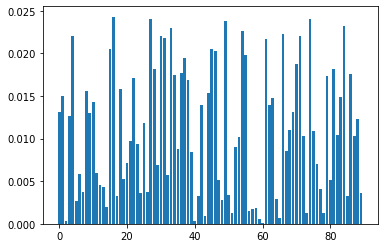

In [ ]:
def scale(x):
    return x / np.sum(np.abs(x))

#random weight
weights = scale(np.random.random(num_stocks))
plt.bar(np.arange(num_stocks),weights)

Step 2: Compute VaR and CVaR

In [ ]:
value_invested = 10000

def value_at_risk(
    value_invested, 
    returns, weights, 
    alpha=0.95, 
    lookback_days=500
):
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    
    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

In [ ]:
"""First, replace any NaNs with 0.0s in the DataFrame of returns. 
Then take the last few days of returns and multiply them by the portfolio weights to create portfolio returns. 
Finally, compute VaR by taking the 5th percentile of returns and multiplying it by the value invested. 
This gets the amount you can expect to lose in one day with 95% confidence.

This is the main difference between VaR and CVaR. 
VaR represents a worst-case loss associated with a probability and a time horizon. 
CVaR is the expected loss if that worst-case threshold is crossed. 
In other words, CVaR quantifies the expected losses that occur beyond the VaR cutoff. 
VaR only measures the cutoff.
"""

def cvar(
    value_invested, 
    returns, 
    weights, 
    alpha=0.95, 
    lookback_days=500
):
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days=lookback_days)
    
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    var_pct_loss = var / value_invested
    
    return np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss]) * value_invested

#Compute VaR to get the cutoff point on the distribution that equals the 5th percentile. 
#Then compute the portfolio returns and convert VaR back to a percentage instead of a dollar amount. 
#To compute CVaR, take the average of all returns less than VaR and multiply by the invested value.
#Taking the average of all returns less than VaR is the same as taking the area of the distribution left of that cutoff point.

Step 3: Vizualize the difference between the two

In [ ]:
cvar(value_invested, returns, weights)

-257.3233033389042

In [ ]:
value_at_risk(value_invested, returns, weights)

-184.86090284405512

CVaR is a bigger negative number than VaR. 
The difference between the two is the extra information CVaR captures by taking the average of all returns less than VaR. 
If you are dependent on VaR for risk management, you miss that information.



Text(0, 0.5, 'Observation Frequency')

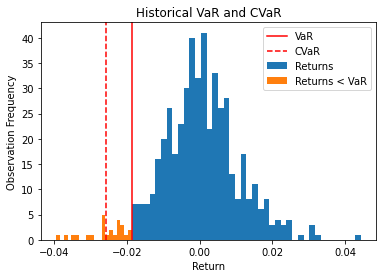

In [ ]:
lookback_days = 500

portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights)
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights)
portfolio_CVaR_return = portfolio_CVaR / value_invested

plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=40)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=20)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid')
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed')
plt.legend(['VaR', 'CVaR', 'Returns', 'Returns < VaR'])
plt.title('Historical VaR and CVaR')
plt.xlabel('Return')
plt.ylabel('Observation Frequency')

# Fama-French factor model

In [ ]:
# pandas_datareader to download the factor data and yfinance to download stock price data. 
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf

# Use statsmodels for modeling.
import statsmodels.api as sm
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS

In [ ]:
factors = pdr.get_data_famafrench(
    'F-F_Research_Data_Factors',
    start='2000-01-01'
)[0][1:]

SMB = factors.SMB
HML = factors.HML

SMB is “small minus big” representing the size factor. 
HML is “high minus low” representing the style factor. 
This also downloads a third factor, Rm-Rf, which is the market excess return. 
I only use SMB and HML for this analysis.

Now get the stock price data for your portfolio. You can pick any stocks you want. (Make sure to include a benchmark like SPY.)

In [ ]:
data = yf.download(
    ['SPY', 'MSFT', 'AAPL', 'INTC'], 
    start="2000-01-01", 
    interval="1mo"
)['Adj Close']

monthly_returns = data.pct_change().to_period("M")

[*********************100%***********************]  4 of 4 completed


/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


The factor data is monthly so to align with the stock data, you need to get monthly closing prices and resample to monthly labels. pandas makes it easy.

Step 2: Compute the sensitivities to the factors
Next, compute the active return of the portfolio. The active return is the portfolio return minus the benchmark return.

In [ ]:
bench = monthly_returns.pop("SPY")
R = monthly_returns.mean(axis=1)
active = R - bench

In [ ]:
# Use regression to compute the sensitivities to the factors.

df = pd.DataFrame({
    'R': active,
    'F1': SMB,
    'F2': HML,
}).dropna()

b1, b2 = regression.linear_model.OLS(
    df.R, 
    df[['F1', 'F2']]
).fit().params

print(f'Sensitivities of active returns to factors:\nSMB: {b1}\nHML: {b2}')

Sensitivities of active returns to factors:
SMB: 0.0023745097246578154
HML: -0.005587731515951416


Put the active returns and factors into a DataFrame to make it easy to align the dates. Then run a regression with the active returns as the dependent variable on the factors. Fitting the model gives you the two coefficients that determine the sensitivities of the portfolio’s active returns to the factors.

The sensitivities are estimates so it’s important to see how they evolve through time with their confidence intervals.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


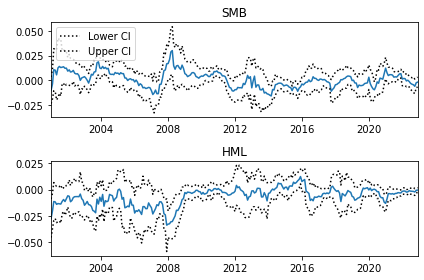

In [ ]:
# endog = bench - factors[exog_vars]
exog_vars = ["SMB", "HML"]
exog = sm.add_constant(factors[exog_vars])
rols = RollingOLS(df.R, exog, window=12)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=exog_vars)

Step 3: Figure out the risk contribution of the factors
Marginal Contribution To Active Risk (MCTAR) measures the incremental active risk each additional factor introduces to your portfolio.

In [ ]:
# The sensitivities tell you how much the active portfolio returns change in response to changes in the factors. 
# In other words, how the factors drive the active portfolio returns.

In [ ]:
F1 = df.F1
F2 = df.F2

cov = np.cov(F1, F2)
ar_squared = (active.std())**2
mcar1 = (b1 * (b2 * cov[0,1] + b1 * cov[0,0])) / ar_squared
mcar2 = (b2 * (b1 * cov[0,1] + b2 * cov[1,1])) / ar_squared
print (f'SMB risk contribution: {mcar1}')
print (f'HML risk contribution: {mcar2}')
print (f'Unexplained risk contribution: {1 - (mcar1 + mcar2)}')

SMB risk contribution: 0.02647248680930316
HML risk contribution: 0.1246494780806092
Unexplained risk contribution: 0.8488780351100876


To figure out the factors’ MCTAR, multiply the factor sensitivity by the covariance between the factors. Then divide by the standard deviation of the active returns, squared.

This tells you how much risk you take on by being exposed to each factor given the other factors you’re already exposed to. The unexplained risk contribution is the exposure you have to other factors outside of the two you analyzed.

You can use this analysis to increase or decrease your exposure to these factors. You would do this by under- or overweighting the stocks that represent these factors (e.g. large cap or value).

# 3 Fama-French factors and the 10 industry portfolios.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

seaborn.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [ ]:
factors = pdr.get_data_famafrench("F-F_Research_Data_Factors", start="1-1-1926")[0]
factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31


The data are monthly returns for the factors or industry portfolios.

In [ ]:
factors = pdr.get_data_famafrench("F-F_Research_Data_Factors", start="1-1-1926")[0]
factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31


In [ ]:
industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
industries.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07,1.45,15.55,4.69,-1.18,2.90,0.83,0.11,1.77,7.04,2.13
1926-08,3.97,3.68,2.81,3.47,2.66,2.17,-0.71,4.25,-1.69,4.35
1926-09,1.14,4.80,1.15,-3.39,-0.38,2.41,0.21,0.69,2.04,0.29
1926-10,-1.24,-8.23,-3.63,-0.78,-4.58,-0.11,-2.29,-0.57,-2.63,-2.84
1926-11,5.20,-0.19,4.10,0.01,4.71,1.63,6.43,5.42,3.71,2.11


The first model estimated is a rolling version of the CAPM that regresses the excess return of Technology sector firms on the excess return of the market.

The window is 60 months, and so results are available after the first 60 (window) months. The first 59 (window - 1) estimates are all nan filled.

In [ ]:
endog = industries.HiTec - factors.RF.values
exog = sm.add_constant(factors["Mkt-RF"])
rols = RollingOLS(endog, exog, window=60)
rres = rols.fit()
params = rres.params.copy()
params.index = np.arange(1, params.shape[0] + 1)
params.head()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,Mkt-RF
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN


In [ ]:
params.iloc[57:62]

,const,Mkt-RF
58,NaN,NaN
59,NaN,NaN
60,0.876155,1.399240
61,0.879936,1.406578
62,0.953169,1.408826


In [ ]:
params.tail()

,const,Mkt-RF
1154,0.400821,1.083680
1155,0.402404,1.097028
1156,0.281329,1.076928
1157,0.319787,1.079756
1158,0.315997,1.086256


We next plot the market loading along with a 95% point-wise confidence interval. The alpha=False omits the constant column, if present.

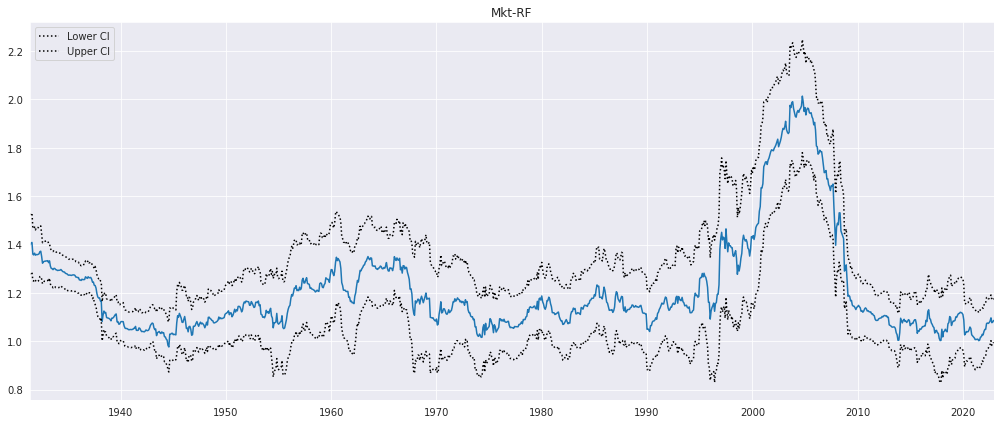

In [ ]:
fig = rres.plot_recursive_coefficient(variables=["Mkt-RF"], figsize=(14, 6))

Next, the model is expanded to include all three factors, the excess market, the size factor and the value factor.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


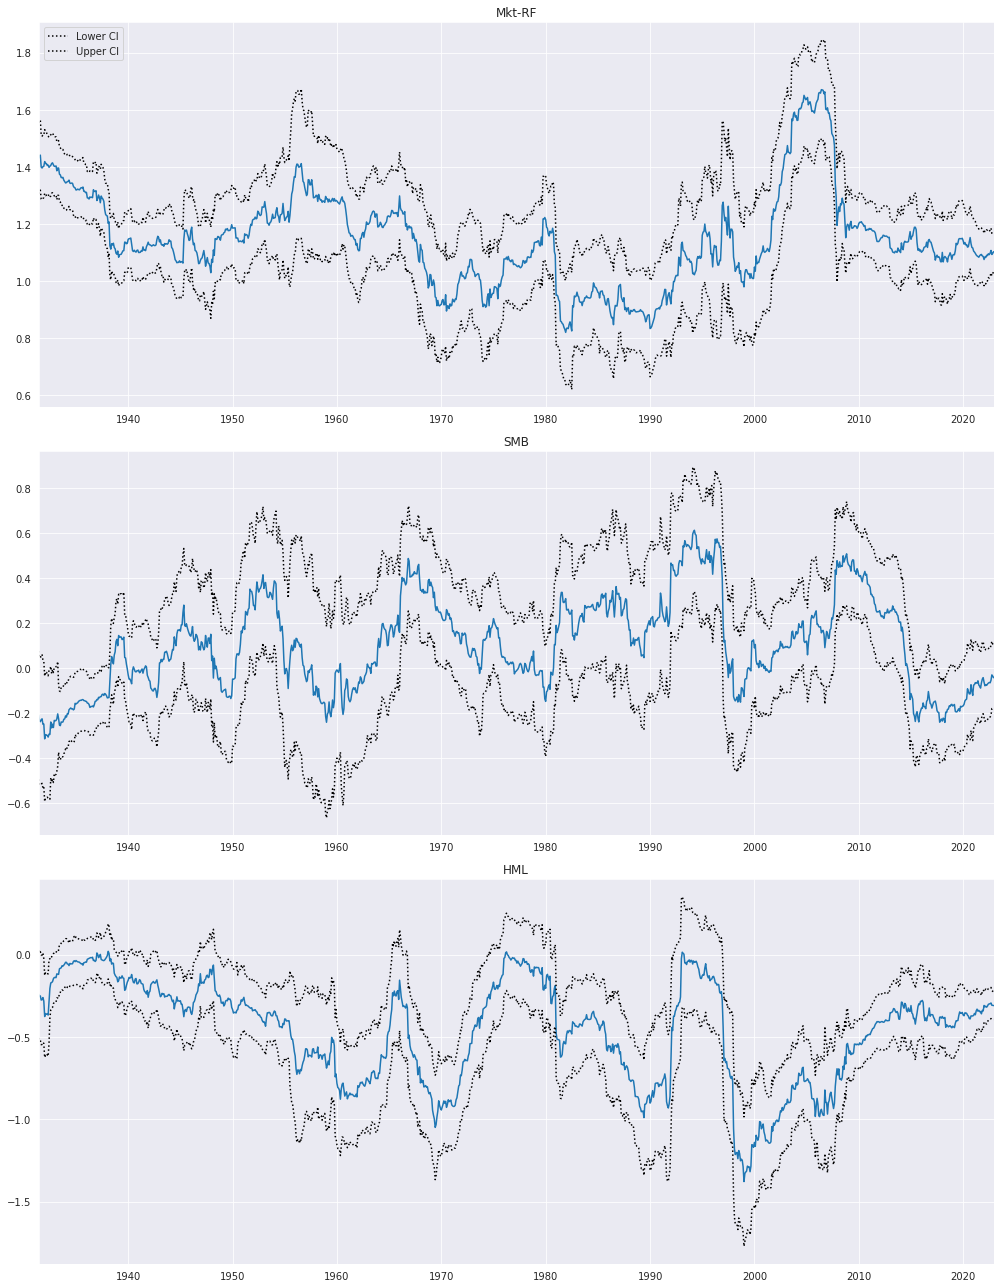

In [ ]:
exog_vars = ["Mkt-RF", "SMB", "HML"]
exog = sm.add_constant(factors[exog_vars])
rols = RollingOLS(endog, exog, window=60)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=exog_vars, figsize=(14, 18))

# Manage portfolio’s risk with value at risk

VaR lets you say something like this:

“With 95% confidence, my portfolio’s loss will not exceed $5000 in one day.

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

import yfinance as yf

In [ ]:
# create your portfolio of stocks
tickers = ["AAPL", "META", "C", "DIS"]

# pick the weights of each stock (must add to 1)
weights = np.array([0.25, 0.3, 0.15, 0.3])

# the size of the portfolio
portfolio_value = 10000

# the confidence interval (95%)
confidence = 0.05

In [ ]:
data = yf.download(tickers, start="2018-01-01", end="2021-12-31")["Close"]

[*********************100%***********************]  4 of 4 completed


Computing portfolio returns is not as simple as just adding up the returns of the individual stocks. We need to take the covariance between the stocks in the portfolio into account.

In [ ]:
# compute daily returns of each stock
returns = data.pct_change()

# compute the daily mean returns of each stock
mean_returns = returns.mean()

# compute portfolio mean return
port_mean = mean_returns.dot(weights)

# mean of investment returns
investment_mean = (1 + port_mean) * portfolio_value

# compute the portfolio covariance matrix
cov_matrix = returns.cov()

# compute portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# standard deviation of investment returns
investment_stdev = portfolio_value * port_stdev

First, we get the daily returns of the stocks in the portfolio. From there we get the mean return for all the data. We apply the weights to those returns and multiply them by the portfolio value to get the portfolio mean return.

Then we compute the covariance between the returns, take the square root of the covariance-adjusted weights of the stocks in the portfolio, and compute the portfolio standard deviation.

The portfolio mean and standard deviation are used in the next step.

In [ ]:
# To find the VaR of this portfolio, 
# we start by finding the point on the density plot based on the confidence level, mean, and standard deviation.

# This is where scipy comes in.

# ppf takes a percentage and returns a standard deviation 
# multiplier for what value that percentage occurs at.
# It is equivalent to a one-tail test on the density plot.
percent_point = norm.ppf(confidence, investment_mean, investment_stdev)
# VaR is the portfolio value less this amount.

# calculate the VaR at the confidence interval
value_at_risk = portfolio_value - percent_point

# print it out
f"Portfolio VaR: {value_at_risk}"

'Portfolio VaR: 283.355976039049'

This is the most you can expect to lose in one day with 95% confidence.



Scaling VaR to different time frames
What about over one week? Or one month?

Stock returns increase with the square root of time. Therefore to scale the value at risk, we multiply it by the square root of time. This sounds scary but it’s simple in Python.

Multiply the one-day VaR by the square root of one (day) through the square root of 30 (days).

In [ ]:
value_at_risks = value_at_risk * np.sqrt(range(1, 31))

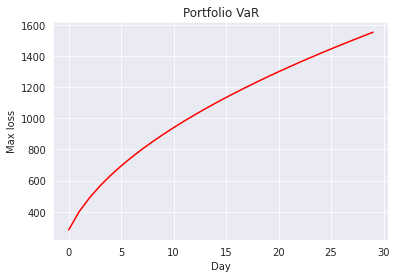

In [ ]:
# build plot of VaR over time
plt.xlabel("Day")
plt.ylabel("Max loss")
plt.title("Portfolio VaR")
plt.plot(value_at_risks, "r")

VaR is a simple measure that comes with various assumptions, caveats, and criticisms. It should be used as one of many risk management techniques. Despite its simplicity, it is a useful tool in the trader’s tool belt.

# Volatility

In [ ]:
import math

import numpy as np
import yfinance as yf

data = yf.download("AAPL", start="2017-01-01", end="2022-06-30")

[*********************100%***********************]  1 of 1 completed


<AxesSubplot: xlabel='Date'>

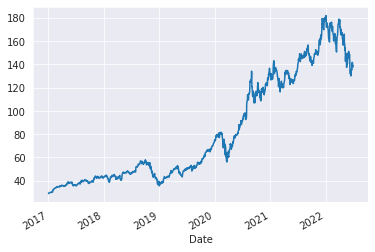

In [ ]:
data['Close'].plot()

Standard Deviation

Standard deviation measures how widely returns are dispersed from the average return. It’s the most common (and biased) estimator of volatility.

In [ ]:
def standard_deviation(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    result = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    if clean:
        return result.dropna()
    else:
        return result


<AxesSubplot: xlabel='Date'>

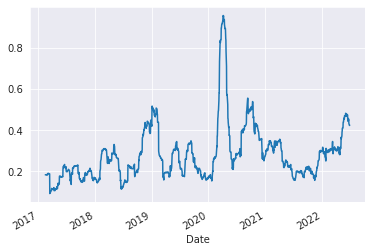

In [ ]:
standard_deviation(data).plot()

Parkinson’s volatility

Parkinson’s volatility uses the stock’s high and low price of the day rather than just close to close prices. It’s useful to capture large price movements during the day.

In [ ]:
def parkinson(price_data, window=30, trading_periods=252, clean=True):

    rs = (1.0 / (4.0 * math.log(2.0))) * (
        (price_data["High"] / price_data["Low"]).apply(np.log)
    ) ** 2.0

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

<AxesSubplot: xlabel='Date'>

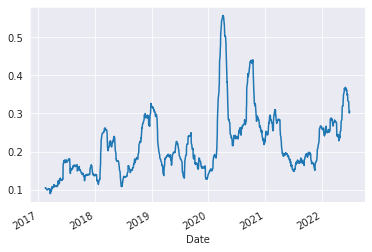

In [ ]:
parkinson(data).plot() 

Garman-Klass

Garman-Klass volatility extends Parkinson’s volatility by taking into account the opening and closing price. As markets are most active during the opening and closing of a trading session, it makes volatility estimation more accurate.

In [ ]:
def garman_klass(price_data, window=30, trading_periods=252, clean=True):

    log_hl = (price_data["High"] / price_data["Low"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = 0.5 * log_hl ** 2 - (2 * math.log(2) - 1) * log_co ** 2

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

<AxesSubplot: xlabel='Date'>

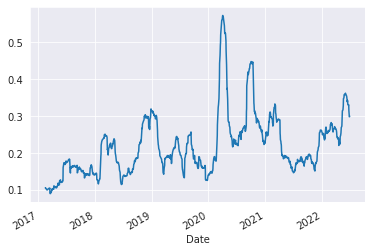

In [ ]:
garman_klass(data).plot()

Hodges-Tompkins

Hodges-Tompkins volatility is a bias correction for estimation using an overlapping data sample that produces unbiased estimates and a substantial gain in efficiency.



In [ ]:
def hodges_tompkins(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    vol = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h ** 2 - 1) / (3 * n ** 2)))

    result = vol * adj_factor

    if clean:
        return result.dropna()
    else:
        return

<AxesSubplot: xlabel='Date'>

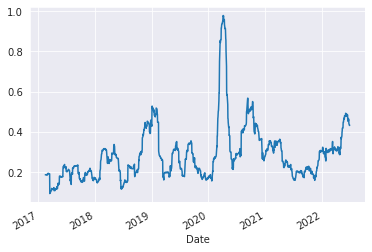

In [ ]:
hodges_tompkins(data).plot()


Rogers-Satchell

Rogers-Satchell is an estimator for measuring the volatility of securities with an average return not equal to zero. Unlike Parkinson and Garman-Klass estimators, Rogers-Satchell incorporates a drift term (mean return not equal to zero).

In [ ]:
def rogers_satchell(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

Yang-Zhang

Yang-Zhang volatility is the combination of the overnight (close-to-open volatility), a weighted average of the Rogers-Satchell volatility and the day’s open-to-close volatility.



In [ ]:
def yang_zhang(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc ** 2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc ** 2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    open_vol = log_oc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    window_rs = rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(
        np.sqrt
    ) * math.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result

<AxesSubplot: xlabel='Date'>

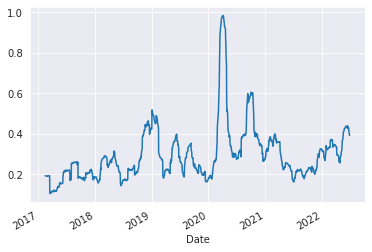

In [ ]:
yang_zhang(data).plot()

# Tail risk with the Omega ratio

The Omega ratio is a weighted ratio of gains and losses above a threshold return. It captures more information about returns than similar metrics like the Sharpe ratio.

It does this by adding up the area under the distribution around the threshold return. The area above the threshold measures the weight of the gains. The area below the threshold measures the weight of the losses. The Omega ratio is the positive area divided by the negative area.

alternative investments have long-tail risks not measured by other metrics like the Sharpe ratio. Even if you’re not investing in exotic derivatives, the Omega ratio is useful.

In [ ]:
import yfinance as yf
import numpy as np

In [ ]:
data = yf.download("AAPL", start="2020-01-01", end="2021-12-31")

returns = data["Adj Close"].pct_change()

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Calculating returns
Y = returns
display(Y.head())

Date
2020-01-02 00:00:00-05:00         NaN
2020-01-03 00:00:00-05:00   -0.009722
2020-01-06 00:00:00-05:00    0.007968
2020-01-07 00:00:00-05:00   -0.004703
2020-01-08 00:00:00-05:00    0.016086
Name: Adj Close, dtype: float64

In [ ]:
# Compute the Omega ratio

In [ ]:
def omega_ratio(returns, required_return=0.0):
    """Determines the Omega ratio of a strategy.
    
    Parameters
    ----------
    returns : pd.Series or np.ndarray
        Daily returns of the strategy, noncumulative.
    required_return : float, optional
        Minimum acceptance return of the investor. Threshold over which to
        consider positive vs negative returns. It will be converted to a
        value appropriate for the period of the returns. E.g. An annual minimum
        acceptable return of 100 will translate to a minimum acceptable
        return of 0.018.

    Returns
    -------
    omega_ratio : float

    Note
    -----
    See <https://en.wikipedia.org/wiki/Omega_ratio> for more details.
    """
    
    return_threshold = (1 + required_return) ** (1 / 252) - 1
    
    returns_less_thresh = returns - return_threshold
    
    numer = sum(returns_less_thresh[returns_less_thresh > 0.0])
    denom = -1.0 * sum(returns_less_thresh[returns_less_thresh < 0.0])
    
    if denom > 0.0:
        return numer / denom
    else:
        return np.nan

First, annualize the return threshold. (The ** syntax in Python is the power operator i.e. 2**2 is 2 squared.) Then, subtract the threshold from the returns. Finally, add up the positive returns less the threshold and negative returns less the threshold.

The Omega ratio is the sum of positive returns less the threshold divided by the sum of negative returns less the threshold.

When analyzing a stock, investment returns, or strategy performance, start with the return distribution. If the returns have skew and kurtosis, consider using the Omega ratio.

Going back to the AAPL example, create a distribution of returns in one line of code.



<AxesSubplot: >

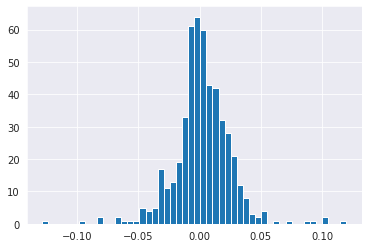

In [ ]:
returns.hist(bins=50)

In [ ]:
returns.skew()

-0.011892744650171226

In [ ]:
returns.kurtosis()

5.349605699829579

The skew (which measures symmetry) is -0.01. A normal distribution has skew of 0. The kurtosis (which measures outliers) is 5.3. A normal distribution has kurtosis of 3.

Using performance metrics that don’t take the entire distribution into consideration misses important information about risk. Use the Omega ratio to capture it.

In [ ]:
omega_ratio(returns, 0.07)

1.2413491261964342

Here, I use a threshold of 7% which is the historical average annual return of the stock market. The Omega ratio is 1.2. Taking into consideration skew and kurtosis, AAPL’s gains outperformed the losses by a factor of 1.2.

Since asset returns are not normally distributed, use the Omega ratio to capture risks other metrics don’t.

# Risk parity portfolio

Risk parity is a strategy that uses risk to find the allocations of an investment portfolio. It allocates money to stocks based on a target risk level – usually volatility.

In other words, instead of equal dollar weights, risk parity portfolios have equal risk weights.

In [ ]:
import numpy as np
import yfinance as yf
import riskfolio as rp
import warnings
warnings.filterwarnings("ignore")
#from riskfolio.src import rps
# from riskfolio.external import *

# https://riskfolio-lib.readthedocs.io/en/latest/install.html

In [ ]:
pip install pybind11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pyscipopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PySCIPOpt-4.2.0.tar.gz (661 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pyscipopt: filename=PySCIPOpt-4.2.0-cp38-cp38-linux_x86_64.whl size=4835573 sha256=9009219fb42608e3196a4f6d59ebaffc059ae3860fca764c917002ccb8da23a8
  Stored in directory: /root/.cache/pip/wheels/d5/35/de/dbf309cec0b3e19be218a04e8dba00eb2cad813082638f17ec
Successfully built pyscipopt


In [ ]:
!sudo apt-get install python3-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.8.2-0ubuntu2).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [ ]:
pip install cvxpy[CBC,CVXOPT,GLOP,GLPK,GUROBI,MOSEK,PDLP,SCIP,XPRESS]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached ortools-9.4.1874-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
  Using cached cylp-0.91.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.4 MB)


In [ ]:
# pip install path/cvxpy‑version.whl

ERROR: cvxpy‑version.whl is not a valid wheel filename.


In [ ]:
!pip install riskfolio-lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install setuptools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# portfolio tickers
assets = ["JCI", "TGT", "CMCSA", "CPB", "MO", "APA", "MMC", "JPM",
          "ZION", "PSA", "BAX", "BMY", "LUV", "PCAR", "TXT", "TMO",
          "DE", "MSFT", "HPQ", "SEE", "VZ", "CNP", "NI", "T", "BA"]

# sort tickers
assets.sort()

#download data
data = yf.download(assets, start="2016-01-01", end="2019-12-30")

# compute non-compounding, daily returns
returns = data['Adj Close'].pct_change().dropna()

[*********************100%***********************]  25 of 25 completed


In [ ]:
# First, setup a portfolio with equal risk weights. This means Riskfolio-Lib will find the weights that cause the risk contribution of each stock to be equal.

port = rp.Portfolio(returns=returns)

port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)

w_rp = port.rp_optimization(
    model="Classic",  # use historical
    rm="MV",  # use mean-variance optimization
    hist=True,  # use historical scenarios
    rf=0,  # set risk free rate to 0
    b=None  # don't use constraints
)

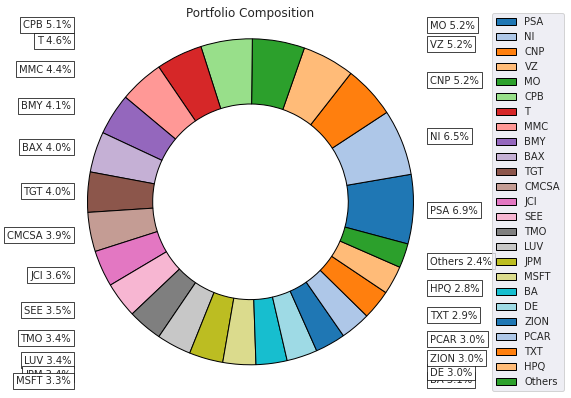

In [ ]:
ax = rp.plot_pie(w=w_rp)

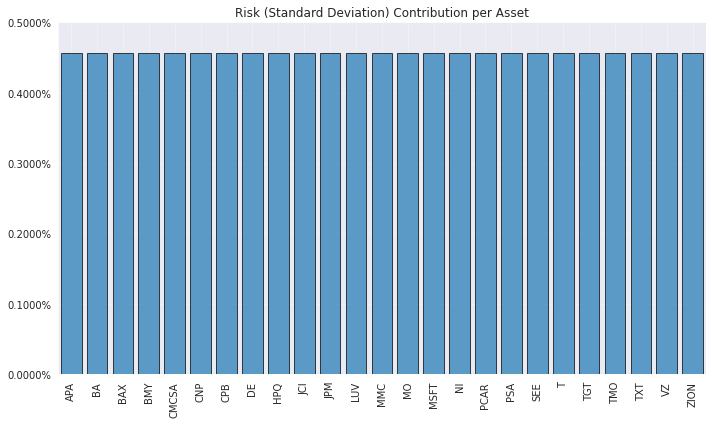

In [ ]:
# show the risk contribution for each asset is equal
ax = rp.plot_risk_con(
    w_rp,
    cov=port.cov,
    returns=port.returns,
    rm="MV",
    rf=0,
)

A criticism of risk parity is that without leverage, returns lag. So add a constraint to weight the stocks in a way to reach a minimum portfolio return. This adds weight to higher-risk stocks to push the portfolio returns higher.

In [ ]:
port.lowerret = 0.0008

# estimate the optimal portfolio with risk parity with the constraint
w_rp_c = port.rp_optimization(
    model="Classic",  # use historical
    rm="MV",  # use mean-variance optimization
    hist=True,  # use historical scenarios
    rf=0,  # set risk free rate to 0
    b=None  # don't use constraints
)

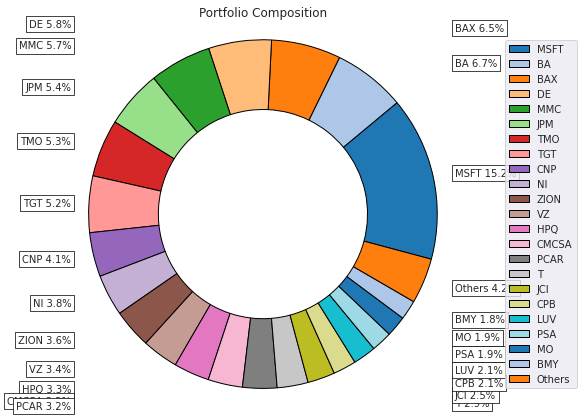

In [ ]:
ax = rp.plot_pie(w=w_rp_c)

MSFT dominates with a 15.3% weight. That’s because to reach the minimum return threshold, risk parity overweights stocks with higher risk. And with higher risk comes higher return.

Plot the risk contributions.



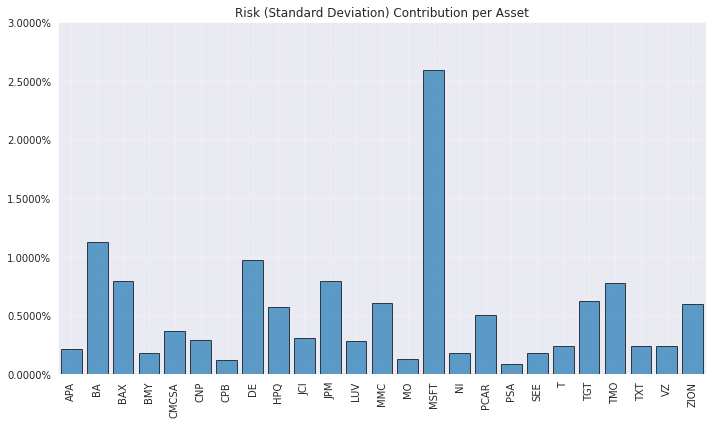

In [ ]:
ax = rp.plot_risk_con(
    w_rp_c,
    cov=port.cov,
    returns=port.returns,
    rm="MV",
    rf=0,
)

They’re no longer equal. That’s because risk parity figured out the **optimal risk weights** to **hit the minimum portfolio return** constraint.

Risk parity is a great way to manage a predictable portfolio that performs consistently in most markets.

# Port Optimisation

In [125]:
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio as rp

# Date range
start = '2016-01-01'
end = '2022-12-30'

# Tickers of assets
tickers = ['TSM', 'GS', 'TQQQ', 'ETH-USD', 'BTC-USD', 'APA', 'MMC', 'JPM',
           'KO', 'PSA', 'BAX', 'BMY', 'TSLA', 'PCAR', 'TXT', 'TMO',
           'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
tickers.sort()

# Downloading the data
data = yf.download(tickers, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = tickers
assets = data.pct_change().dropna()

Y = assets

# Creating the Portfolio Object
port = rp.Portfolio(returns=Y)

# To display dataframes values in percentage format
pd.options.display.float_format = '{:.4%}'.format

# Choose the risk measure
rm = 'MSV'  # Semi Standard Deviation

# Estimate inputs of the model (historical estimates)
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate the portfolio that maximizes the risk adjusted return ratio
w1 = port.optimization(model='Classic', rm=rm, obj='Sharpe', rf=0.0, l=0, hist=True)

# Estimate points in the efficient frontier mean - semi standard deviation
ws = port.efficient_frontier(model='Classic', rm=rm, points=20, rf=0, hist=True)

# Estimate the risk parity portfolio for semi standard deviation
w2 = port.rp_optimization(model='Classic', rm=rm, rf=0, b=None, hist=True)

[*********************100%***********************]  25 of 25 completed


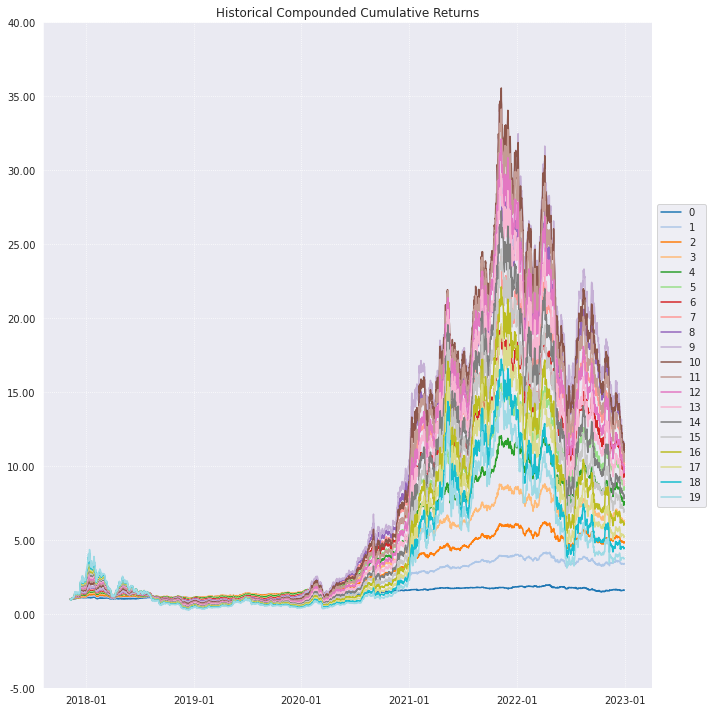

In [126]:
ax = rp.plot_series(returns=Y, w=ws, cmap='tab20', height=10, width=10,
                    ax=None)

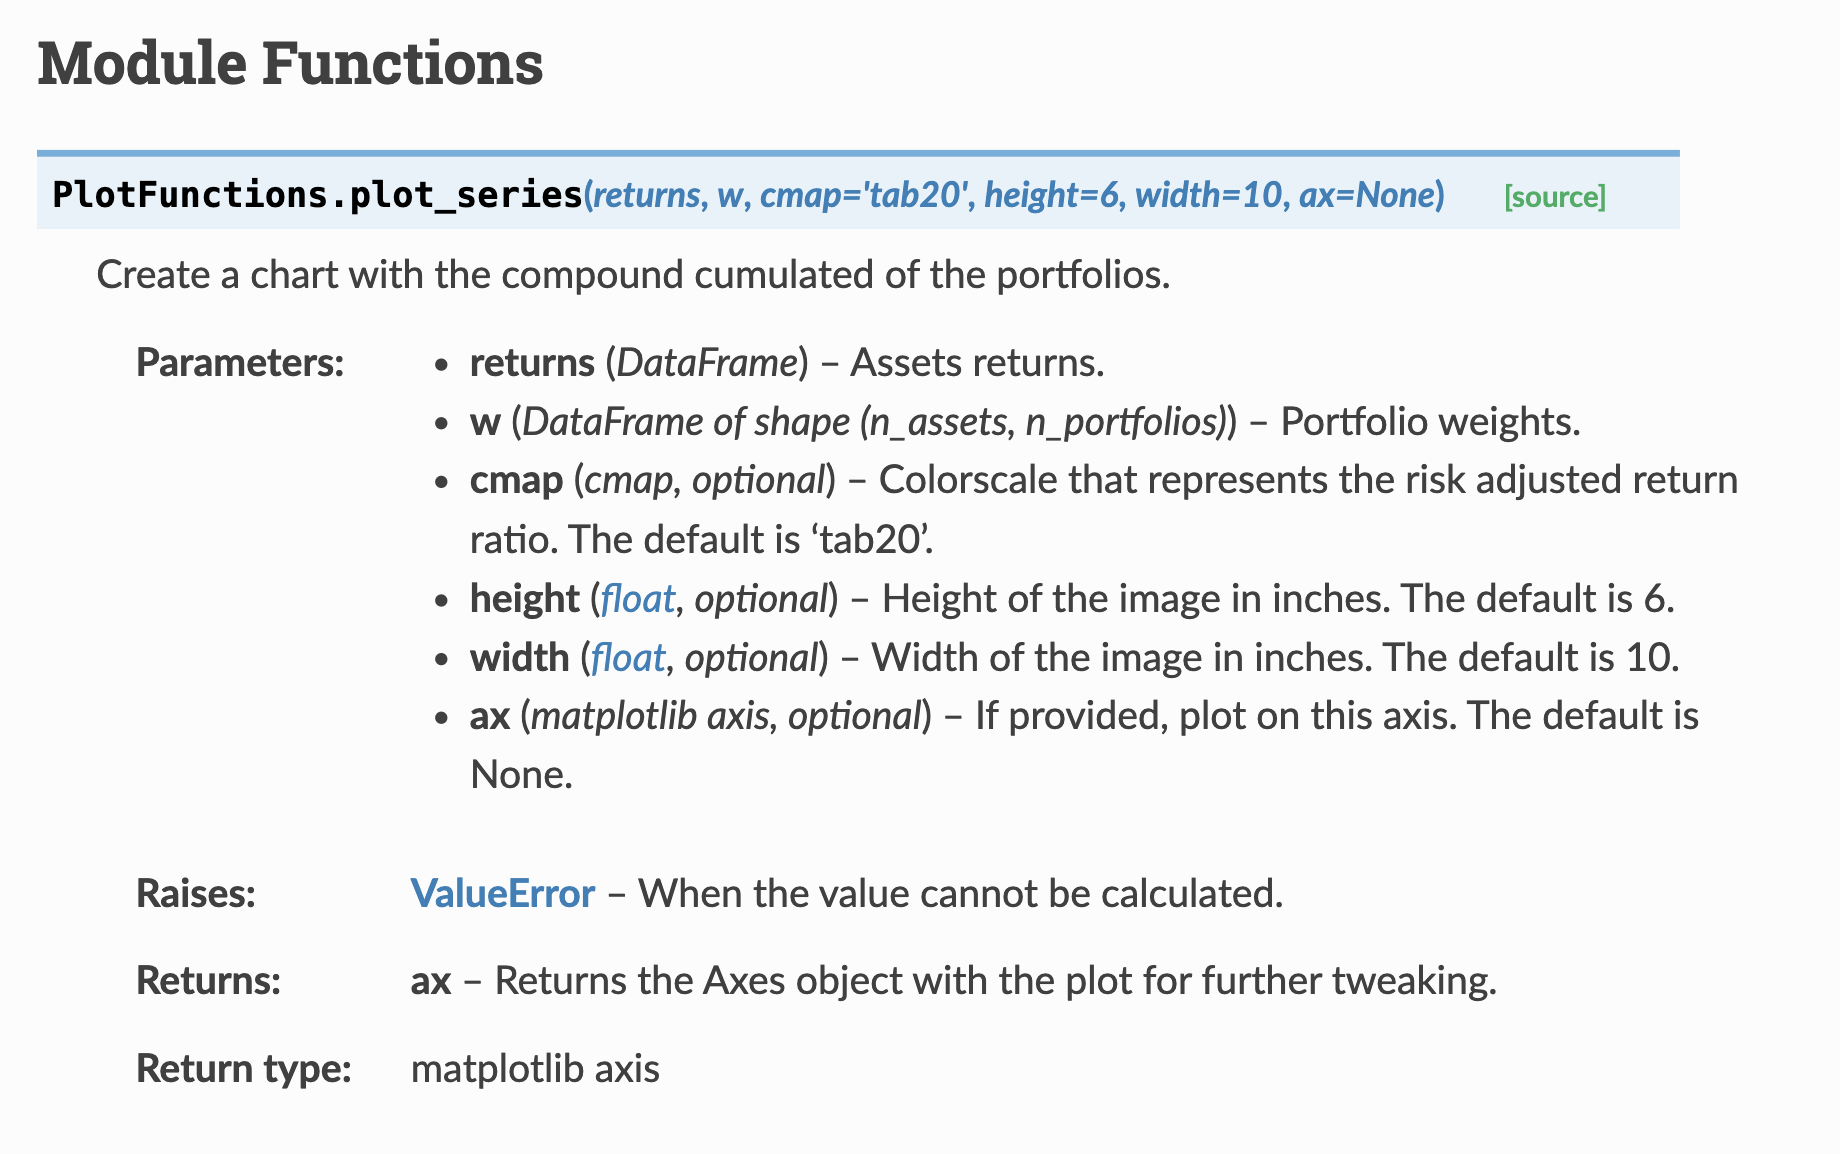

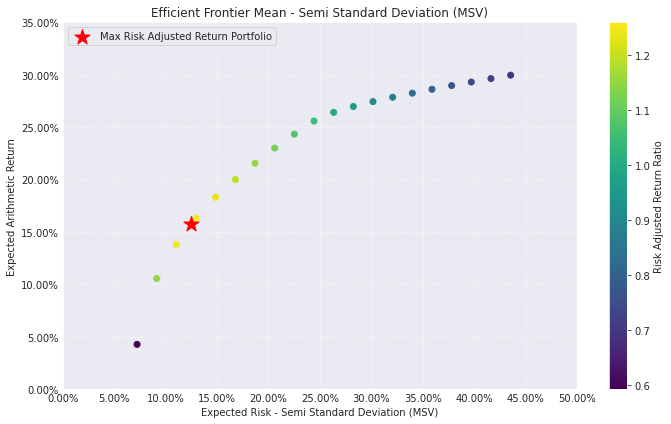

In [133]:
label = 'Max Risk Adjusted Return Portfolio'
mu = port.mu
cov = port.cov
returns = port.returns

ax = rp.plot_frontier(w_frontier=ws, mu=mu, cov=cov, returns=returns,
                       rm=rm, rf=0, alpha=0.05, cmap='viridis', w=w1,
                       label=label, marker='*', s=16, c='r',
                       height=6, width=10, t_factor=252, ax=None)

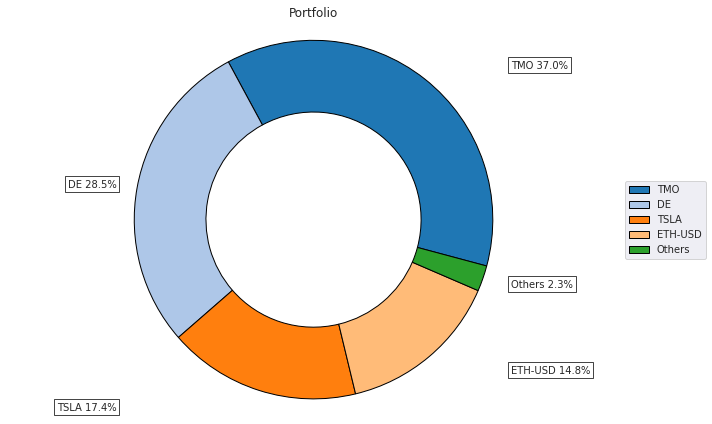

In [134]:
ax = rp.plot_pie(w=w1, title='Portfolio', height=6, width=10,
                 cmap="tab20", ax=None)

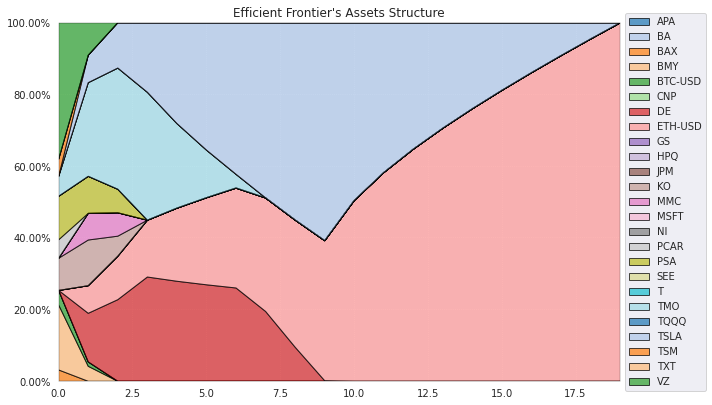

In [136]:
ax = rp.plot_frontier_area(w_frontier=ws, cmap="tab20", height=6,
                           width=10, ax=None)

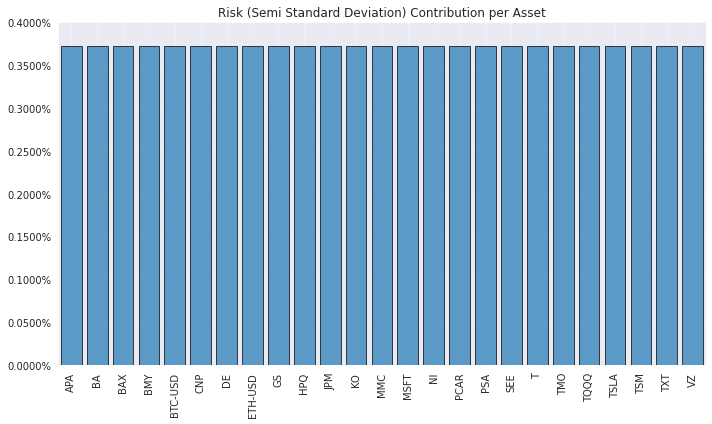

In [137]:
ax = rp.plot_risk_con(w=w2, cov=cov, returns=returns, rm=rm,
                      rf=0, alpha=0.05, color="tab:blue", height=6,
                      width=10, t_factor=252, ax=None)

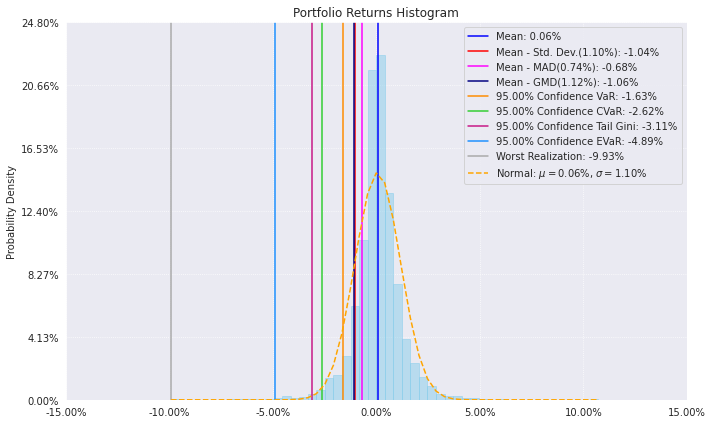

In [140]:
# Create a histogram of portfolio returns with the risk measures.

ax = rp.plot_hist(returns=Y, w=w1, alpha=0.05, bins=50, height=6,
                  width=10, ax=None)


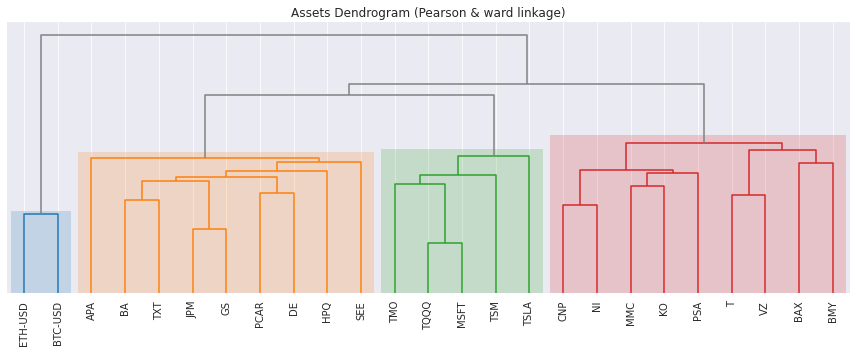

In [155]:
# Create a dendrogram based on the selected codependence measure.

ax = rp.plot_dendrogram(returns=Y,
                        linkage='ward', k=None, max_k=10,
                        leaf_order=True, ax=None)

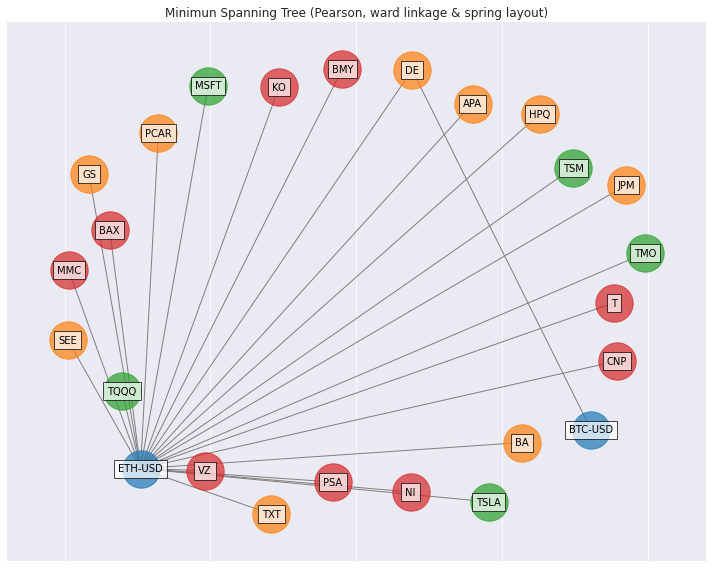

In [156]:
# Create a network plot. The Planar Maximally Filtered Graph (PMFG) for DBHT linkage and Minimum Spanning Tree (MST) for other linkage methods.

ax = rp.plot_network(returns=Y, codependence="pearson",
                     linkage="ward", k=None, max_k=10,
                     alpha_tail=0.05, leaf_order=True,
                     kind='spring', ax=None)

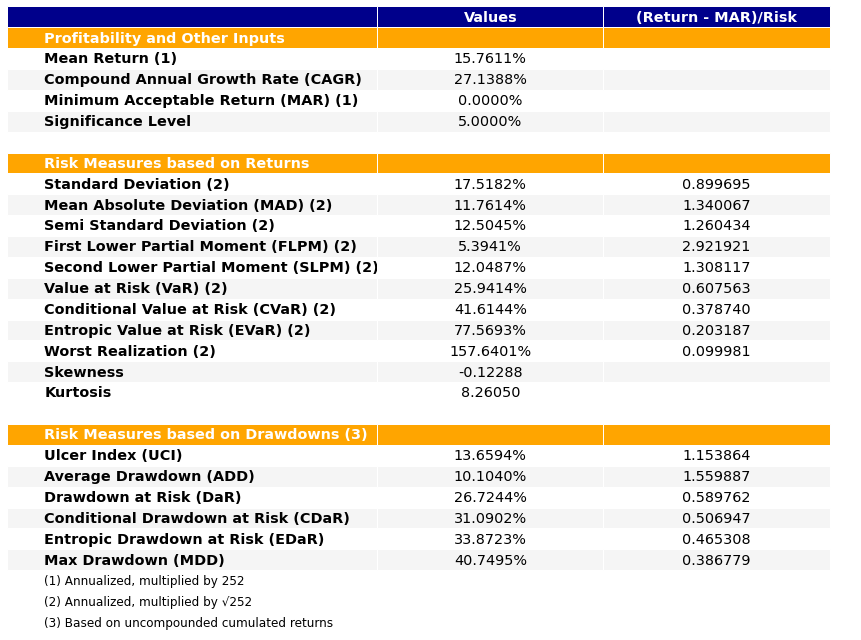

In [143]:
# Create a table with information about risk measures and risk adjusted return ratios.
ax = rp.plot_table(returns=Y, w=w1, MAR=0, alpha=0.05, ax=None)

# Portfolio Optimization with Risk Factors and Principal Components Regression (PCR)


In [211]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2020-01-01'
end = '2022-12-30'

# Tickers of assets
assets = ['ETH-USD', 'TGT', 'BTC-USD', 'MCD', 'GS', 'MA', 'JPM',
          'META', 'QQQ', 'SPY', 'BMY', 'ARKK', 'BABA', 'AMZN', 'TMO',
          'KO', 'MSFT', 'TSLA', 'TSM', 'SQ', 'XRP-USD', 'PDD', 'T', 'BA']

# assets = ['ETH-USD', 'TGT', 'BTC-USD', 'MCD', 'AAPL','PDD']
assets.sort()

# Tickers of factors

factors = ['MTUM', 'QUAL', 'VLUE', 'SIZE', 'USMV']
factors.sort()

tickers = assets + factors
tickers.sort()

# Downloading data
data = yf.download(tickers, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = tickers

[*********************100%***********************]  29 of 29 completed


In [212]:
# Calculating returns

X = data[factors].pct_change().dropna()
Y = data[assets].pct_change().dropna()
display(X.head())

,MTUM,QUAL,SIZE,USMV,VLUE
Date,,,,,
2020-01-03 00:00:00+00:00,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
2020-01-03 05:00:00+00:00,-0.0159%,-0.6478%,-0.4705%,0.0610%,-1.0741%
2020-01-04 00:00:00+00:00,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
2020-01-05 00:00:00+00:00,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
2020-01-06 00:00:00+00:00,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%


In [213]:
# 2.1 Estimating the loadings matrix with PCR.
import riskfolio as rp

feature_selection = 'PCR' # Method to select best model, could be PCR or Stepwise
n_components = 0.95 # 95% of explained variance. See PCA in scikit learn for more information

loadings = rp.loadings_matrix(X=X, Y=Y, feature_selection=feature_selection,n_components=n_components)

loadings.style.format("{:.4f}").background_gradient(cmap='RdYlGn')

,const,MTUM,QUAL,SIZE,USMV,VLUE
AMZN,-0.0001,0.8486,0.1866,-0.0018,0.1420,-0.2390
ARKK,-0.0003,1.1689,0.3018,0.0500,0.2521,-0.2666
BA,-0.0002,-0.5252,0.3416,0.5380,0.4892,0.7867
BABA,-0.0004,0.6455,0.1676,0.0287,0.1404,-0.1460
BMY,0.0001,0.0122,0.1084,0.1242,0.1356,0.1443
BTC-USD,0.0009,-0.0010,-0.0003,-0.0001,-0.0002,0.0002
ETH-USD,0.0020,-0.0021,-0.0006,-0.0001,-0.0005,0.0004
GS,0.0002,-0.3116,0.2510,0.3759,0.3512,0.5343
JPM,-0.0000,-0.5385,0.2474,0.4308,0.3717,0.6629
KO,0.0001,-0.1972,0.1522,0.2301,0.2139,0.3288


In [214]:
# 2.2 Calculating the portfolio that maximizes Sharpe ratio.

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov)

feature_selection = 'PCR' # Method to select best model, could be PCR or Stepwise
n_components = 0.95 # 95% of explained variance. See PCA in scikit learn for more information

port.factors = X
port.factors_stats(method_mu=method_mu,
                   method_cov=method_cov,
                   dict_risk=dict(feature_selection=feature_selection,
                                  n_components=n_components)
                  )

# Estimate optimal portfolio:

model='FM' # Factor Model
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AMZN,ARKK,BA,BABA,BMY,BTC-USD,ETH-USD,GS,JPM,KO,...,PDD,QQQ,SPY,SQ,T,TGT,TMO,TSLA,TSM,XRP-USD
weights,0.0000%,0.0000%,0.0000%,0.0000%,0.5610%,18.2160%,22.5077%,6.8603%,0.0000%,0.0000%,...,8.5128%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,13.5755%,18.6155%,0.0000%,10.6586%


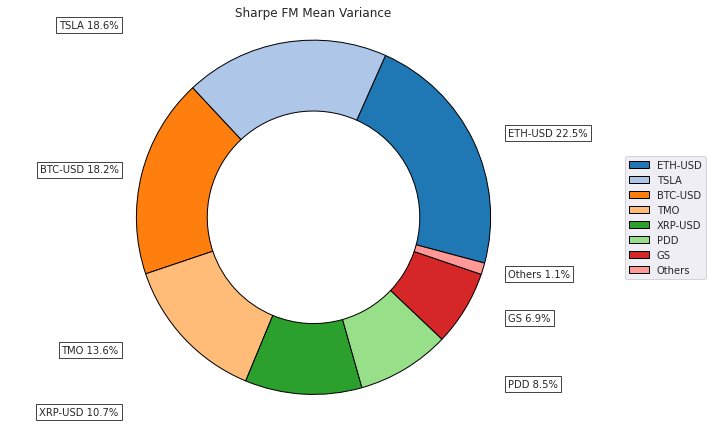

In [215]:
# 2.3 Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe FM Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)


In [216]:

points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AMZN,ARKK,BA,BABA,BMY,BTC-USD,ETH-USD,GS,JPM,KO,...,PDD,QQQ,SPY,SQ,T,TGT,TMO,TSLA,TSM,XRP-USD
0,0.9672%,0.0000%,0.0000%,1.5100%,36.0270%,6.1607%,3.4765%,0.0000%,0.0000%,20.6775%,...,0.4579%,0.0000%,0.0000%,0.0000%,10.7271%,1.2711%,8.0820%,0.0000%,0.0000%,2.2043%
1,0.0000%,0.0000%,0.0000%,0.0000%,29.4665%,9.2902%,8.4145%,0.0000%,0.0000%,18.9081%,...,2.8282%,0.0000%,0.0000%,0.0000%,0.0000%,1.4820%,12.2816%,2.1079%,0.0000%,4.3983%
2,0.0000%,0.0000%,0.0000%,0.0000%,25.3544%,10.6885%,10.6270%,0.0000%,0.0000%,15.9510%,...,3.7257%,0.0000%,0.0000%,0.0000%,0.0000%,0.7928%,12.7718%,4.7579%,0.0000%,5.3806%
3,0.0000%,0.0000%,0.0000%,0.0000%,22.0235%,11.8211%,12.4191%,0.0000%,0.0000%,13.5552%,...,4.4529%,0.0000%,0.0000%,0.0000%,0.0000%,0.2346%,13.1684%,6.9044%,0.0000%,6.1763%
4,0.0000%,0.0000%,0.0000%,0.0000%,19.0165%,12.8257%,14.0102%,0.0000%,0.0000%,11.3406%,...,5.0950%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,13.4795%,8.8014%,0.0000%,6.8826%


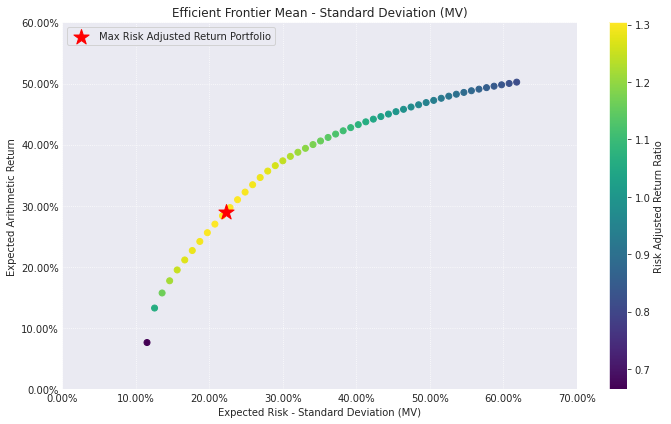

In [217]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu_fm # Expected returns
cov = port.cov_fm # Covariance matrix
returns = port.returns_fm # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.01, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

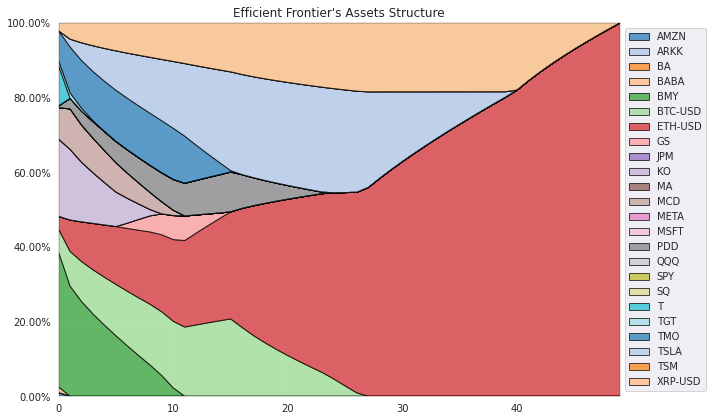

In [218]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In this part I will calculate optimal portfolios for several risk measures using a mean estimate based on PCR. I will find the portfolios that maximize the risk adjusted return for all available risk measures.

3.1 Calculate Optimal Portfolios for Several Risk Measures.

In [220]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

# When we use hist = True the risk measures all calculated
# using historical returns, while when hist = False the
# risk measures are calculated using the expected returns 
#  based on risk factor model: R = a + B * F

hist = False

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [221]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')


,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
AMZN,0.00%,0.02%,0.01%,0.13%,0.09%,0.01%,0.02%,0.01%,0.12%,0.12%,0.15%,0.04%,0.02%
ARKK,0.00%,0.01%,0.01%,0.10%,0.06%,0.01%,0.01%,0.01%,0.08%,0.11%,0.11%,0.03%,0.02%
BA,0.00%,0.00%,0.00%,0.07%,0.05%,0.00%,0.00%,0.01%,0.06%,0.08%,0.07%,0.03%,0.02%
BABA,0.00%,0.02%,0.01%,0.10%,0.09%,0.01%,0.01%,0.01%,0.08%,0.13%,0.11%,0.03%,0.02%
BMY,0.56%,0.01%,0.02%,0.13%,0.15%,0.01%,0.01%,0.01%,0.17%,0.12%,0.17%,0.04%,0.02%
BTC-USD,18.22%,0.11%,2.02%,0.08%,1.95%,36.33%,0.06%,0.64%,0.72%,0.26%,0.21%,88.23%,0.03%
ETH-USD,22.51%,99.06%,88.63%,97.94%,88.39%,31.89%,99.50%,56.44%,91.16%,94.98%,80.27%,2.35%,99.44%
GS,6.86%,0.00%,0.01%,0.05%,0.07%,0.00%,0.01%,0.01%,0.06%,0.04%,0.04%,0.04%,0.02%
JPM,0.00%,0.00%,0.01%,0.07%,0.07%,0.00%,0.01%,0.01%,0.08%,0.07%,0.07%,0.04%,0.02%
KO,0.00%,0.01%,0.01%,0.10%,0.11%,0.01%,0.01%,0.01%,0.12%,0.09%,0.11%,0.05%,0.02%


<AxesSubplot: >

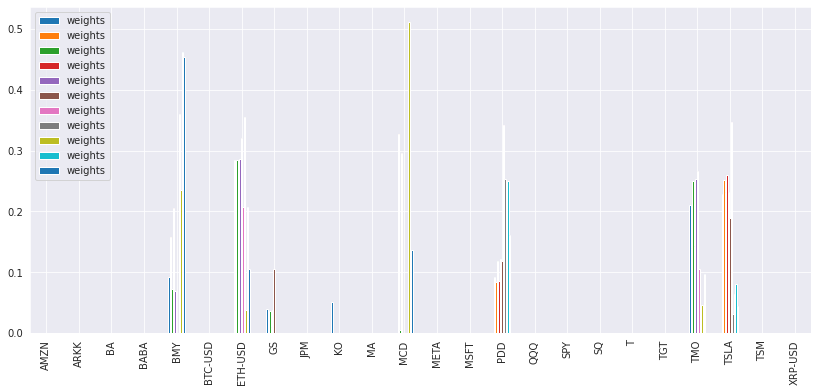

In [226]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

In [ ]:
w_s = pd.DataFrame([])

# When we use hist = True the risk measures all calculated
# using historical returns, while when hist = False the
# risk measures are calculated using the expected returns 
# based on risk factor model: R = a + B * F

# hist = True

# for i in rms:
#     w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=True)
#     w_s = pd.concat([w_s, w], axis=1)
    
# w_s.columns = rms


rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

# When we use hist = True the risk measures all calculated
# using historical returns, while when hist = False the
# risk measures are calculated using the expected returns 
#  based on risk factor model: R = a + B * F

hist = True

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [ ]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

In [ ]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

# Logarithmic Mean Risk Optimization (Kelly Criterion)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2000-01-01'
end = '2019-12-31'

# Tickers of assets
assets = ['AIG', 'AKAM', 'AMT', 'APA', 'BA', 'BAX', 'BKNG',
          'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'MO', 'MSFT', 'NI',
          'NKTR', 'NTAP', 'PCAR', 'PSA', 'REGN', 'SBAC', 'SEE', 'T',
          'TGT', 'TMO', 'TTWO']

assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  26 of 26 completed


In [ ]:
# Calculating returns

#Y = data[assets].pct_change().dropna()
Y = data[assets].copy()
Y = Y.resample('M').last().pct_change().dropna()
print(Y.shape)
display(Y.head())

(239, 26)


,AIG,AKAM,AMT,APA,BA,BAX,BKNG,BMY,CMCSA,CNP,...,NTAP,PCAR,PSA,REGN,SBAC,SEE,T,TGT,TMO,TTWO
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29 00:00:00-05:00,-15.2695%,4.8670%,37.2822%,0.0000%,-16.7100%,-14.6771%,-3.5560%,-13.5849%,-7.2464%,-8.3353%,...,88.0448%,4.6443%,-2.7548%,358.8832%,33.6083%,-11.4700%,-11.9533%,-10.2961%,-9.7473%,0.0000%
2000-03-31 00:00:00-05:00,23.8863%,-38.4450%,0.2538%,36.5170%,2.3688%,15.0229%,43.0168%,-0.2184%,3.1250%,14.5897%,...,-12.3178%,16.1103%,-3.8081%,-47.6770%,8.6420%,9.3082%,11.5894%,26.6949%,30.4000%,6.5327%
2000-04-30 00:00:00-04:00,0.1712%,-38.5154%,-5.6962%,-2.6381%,4.9587%,8.5878%,-20.9375%,-7.8649%,-5.4545%,12.9973%,...,-10.6496%,-4.8750%,6.5476%,-3.3827%,-7.6705%,2.4166%,4.7667%,-10.9532%,-4.9080%,-27.3585%
2000-05-31 00:00:00-04:00,2.6662%,-32.4905%,-20.2684%,25.6128%,-1.2138%,2.1113%,-39.7233%,5.0059%,-3.6858%,8.7705%,...,-12.6796%,-11.3612%,-0.2793%,-28.6652%,-8.3077%,0.6742%,-0.2852%,-5.6897%,-4.1936%,-5.8442%
2000-06-30 00:00:00-04:00,4.3864%,77.8792%,12.2896%,-3.3384%,7.0400%,5.7331%,-0.3689%,5.7889%,3.4941%,3.5011%,...,24.6854%,-5.2238%,6.1299%,46.3190%,39.4295%,-6.4732%,0.7153%,-7.4775%,13.4681%,33.7931%


In [ ]:
# 2.1 Calculating the portfolio that maximizes Risk Adjusted Return.

import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

port.solvers = ['MOSEK']
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters


ValueError: ignored

In [169]:
w1.plot(kind='bar', ax = ax)

AttributeError: ignored

# `BACKTESTING`

In [ ]:
pip install backtrader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.1/410.1 KB 7.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import datetime
import yfinance as yf
import backtrader as bt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Date range
start = '2010-01-01'
end = '2020-12-31'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA','SPY']
assets.sort()

# Downloading data
prices = yf.download(assets, start=start, end=end)
display(prices.head())
prices = prices.dropna()

[*********************100%***********************]  26 of 26 completed


Adj Close                                   \
                                 APA         BA        BAX        BMY   
Date                                                                    
2010-01-04 00:00:00-05:00 8659.1576% 4377.7550% 2494.1332% 1684.7435%   
2010-01-05 00:00:00-05:00 8761.3968% 4521.1342% 2477.0184% 1658.4501%   
2010-01-06 00:00:00-05:00 8898.8045% 4658.2802% 2485.5761% 1657.7927%   
2010-01-07 00:00:00-05:00 8763.8504% 4846.8559% 2525.7961% 1659.1068%   
2010-01-08 00:00:00-05:00 8718.0466% 4800.1011% 2531.7867% 1631.4997%   

                                                                     \
                              CMCSA       CNP        CPB         DE   
Date                                                                  
2010-01-04 00:00:00-05:00 657.6559% 868.1852% 2284.9859% 4304.3911%   
2010-01-05 00:00:00-05:00 648.7424% 861.6080% 2289.0337% 4288.2679%   
2010-01-06 00:00:00-05:00 644.0921% 853.2370% 2263.3982% 4276.7487%   
2010-01-07 00:00:00-05:00 657.6559% 861.6080% 2228.9921% 4307.4627%   
2010-01-08 00:00:00-05:00 655.7184% 851.4433% 2214.8245% 4424.9397%   

                                                 ...   Volume           \
                                 HPQ        JCI  ...     PCAR      PSA   
Date                                             ...                     
2010-01-04 00:00:00-05:00 1700.7954% 1252.6976%  ...  2631700  1579100   
2010-01-05 00:00:00-05:00 1707.9292% 1246.4809%  ...  2299300  1131000   
2010-01-06 00:00:00-05:00 1692.0401% 1242.3367%  ...  3565000   832400   
2010-01-07 00:00:00-05:00 1692.6893% 1251.3160%  ...  2455700  1284100   
2010-01-08 00:00:00-05:00 1705.3358% 1255.4606%  ...  2404300  1281100   

                                                                            \
                               SEE        SPY         T       TGT      TMO   
Date                                                                         
2010-01-04 00:00:00-05:00   920400  118944600  38576858   4589100  7182800   
2010-01-05 00:00:00-05:00   831400  111579900  46650478   4760100  3221900   
2010-01-06 00:00:00-05:00  1334400  116074400  50172450   7217400  3065000   
2010-01-07 00:00:00-05:00  1394900  131091100  44486797  12531000  2638300   
2010-01-08 00:00:00-05:00   702900  126402800  36586622   6512800  3162200   

                                                         
                                TXT        VZ      ZION  
Date                                                     
2010-01-04 00:00:00-05:00   3630600  16176648   3974600  
2010-01-05 00:00:00-05:00  12121100  23722957   5605500  
2010-01-06 00:00:00-05:00   5598300  37506464  12615200  
2010-01-07 00:00:00-05:00   5196100  25508242  24716800  
2010-01-08 00:00:00-05:00   4104000  20658308   6903000  

[5 rows x 156 columns]

In [ ]:
display(prices.head())

Adj Close                                   \
                                 APA         BA        BAX        BMY   
Date                                                                    
2010-01-04 00:00:00-05:00 8659.1576% 4377.7550% 2494.1332% 1684.7435%   
2010-01-05 00:00:00-05:00 8761.3968% 4521.1342% 2477.0184% 1658.4501%   
2010-01-06 00:00:00-05:00 8898.8045% 4658.2802% 2485.5761% 1657.7927%   
2010-01-07 00:00:00-05:00 8763.8504% 4846.8559% 2525.7961% 1659.1068%   
2010-01-08 00:00:00-05:00 8718.0466% 4800.1011% 2531.7867% 1631.4997%   

                                                                     \
                              CMCSA       CNP        CPB         DE   
Date                                                                  
2010-01-04 00:00:00-05:00 657.6559% 868.1852% 2284.9859% 4304.3911%   
2010-01-05 00:00:00-05:00 648.7424% 861.6080% 2289.0337% 4288.2679%   
2010-01-06 00:00:00-05:00 644.0921% 853.2370% 2263.3982% 4276.7487%   
2010-01-07 00:00:00-05:00 657.6559% 861.6080% 2228.9921% 4307.4627%   
2010-01-08 00:00:00-05:00 655.7184% 851.4433% 2214.8245% 4424.9397%   

                                                 ...   Volume           \
                                 HPQ        JCI  ...     PCAR      PSA   
Date                                             ...                     
2010-01-04 00:00:00-05:00 1700.7954% 1252.6976%  ...  2631700  1579100   
2010-01-05 00:00:00-05:00 1707.9292% 1246.4809%  ...  2299300  1131000   
2010-01-06 00:00:00-05:00 1692.0401% 1242.3367%  ...  3565000   832400   
2010-01-07 00:00:00-05:00 1692.6893% 1251.3160%  ...  2455700  1284100   
2010-01-08 00:00:00-05:00 1705.3358% 1255.4606%  ...  2404300  1281100   

                                                                            \
                               SEE        SPY         T       TGT      TMO   
Date                                                                         
2010-01-04 00:00:00-05:00   920400  118944600  38576858   4589100  7182800   
2010-01-05 00:00:00-05:00   831400  111579900  46650478   4760100  3221900   
2010-01-06 00:00:00-05:00  1334400  116074400  50172450   7217400  3065000   
2010-01-07 00:00:00-05:00  1394900  131091100  44486797  12531000  2638300   
2010-01-08 00:00:00-05:00   702900  126402800  36586622   6512800  3162200   

                                                         
                                TXT        VZ      ZION  
Date                                                     
2010-01-04 00:00:00-05:00   3630600  16176648   3974600  
2010-01-05 00:00:00-05:00  12121100  23722957   5605500  
2010-01-06 00:00:00-05:00   5598300  37506464  12615200  
2010-01-07 00:00:00-05:00   5196100  25508242  24716800  
2010-01-08 00:00:00-05:00   4104000  20658308   6903000  

[5 rows x 156 columns]

In [ ]:
############################################################
# Defining the backtest function 
############################################################

def backtest(datas, strategy, start, end, plot=False, **kwargs):
    cerebro = bt.Cerebro()

    # Here we add transaction costs and other broker costs
    cerebro.broker.setcash(1000000.0)
    cerebro.broker.setcommission(commission=0.005) # Commission 0.5%
    cerebro.broker.set_slippage_perc(0.005, # Slippage 0.5%
                                     slip_open=True,
                                     slip_limit=True,
                                     slip_match=True,
                                     slip_out=False)
    for data in datas:
        cerebro.adddata(data)

    # Here we add the indicators that we are going to store
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    results = cerebro.run(stdstats=False)
    if plot:
        cerebro.plot(iplot=False, start=start, end=end)
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

In [ ]:
############################################################
# Create objects that contain the prices of assets
############################################################

# Creating Assets bt.feeds
assets_prices = []
for i in assets:
    if i != 'SPY':
        prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), i)].dropna()
        prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
        assets_prices.append(bt.feeds.PandasData(dataname=prices_, plot=False))

# Creating Benchmark bt.feeds        
prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), 'SPY')].dropna()
prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
benchmark = bt.feeds.PandasData(dataname=prices_, plot=False)

display(prices_.head())

,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04 00:00:00-05:00,11333.0002%,11338.9999%,11151.0002%,11237.0003%,118944600
2010-01-05 00:00:00-05:00,11362.9997%,11368.0000%,11284.9998%,11326.0002%,111579900
2010-01-06 00:00:00-05:00,11370.9999%,11398.9998%,11343.0000%,11351.9997%,116074400
2010-01-07 00:00:00-05:00,11419.0002%,11433.0002%,11318.0000%,11350.0000%,131091100
2010-01-08 00:00:00-05:00,11457.0000%,11462.0003%,11366.0004%,11388.9999%,126402800


In [ ]:
############################################################
# Building the Buy and Hold strategy
############################################################

class BuyAndHold(bt.Strategy):

    def __init__(self):
        self.counter = 0

    def next(self):
        if self.counter >= 1004:
            if self.getposition(self.data).size == 0:
                self.order_target_percent(self.data, target=0.99)
        self.counter += 1 

In [ ]:
from matplotlib.dates import (HOURS_PER_DAY, MIN_PER_HOUR, SEC_PER_MIN,
                              MONTHS_PER_YEAR, DAYS_PER_WEEK,
                              SEC_PER_HOUR, SEC_PER_DAY,
                              num2date, rrulewrapper, YearLocator,
                              MicrosecondLocator)

In [ ]:
pip install matplotlib==3.3.0.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
from matplotlib.dates import (HOURS_PER_DAY, MIN_PER_HOUR, SEC_PER_MIN,
                              MONTHS_PER_YEAR, DAYS_PER_WEEK,
                              SEC_PER_HOUR, SEC_PER_DAY,
                              num2date, rrulewrapper, YearLocator,
                              MicrosecondLocator)

In [ ]:
############################################################
# Run the backtest for the selected period
############################################################
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.plot() # We need to do this to avoid errors in inline plot

start = 1004
end = prices.shape[0] - 1

dd, cagr, sharpe = backtest([benchmark], BuyAndHold,start=start,end=end,plot=True)


ImportError: ignored

In [157]:
############################################################
# Show Buy and Hold Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

NameError: ignored

# Mean Kurtosis Optimization

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'AMZN', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'AAPL', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  25 of 25 completed


In [ ]:
# Calculating returns

Y = data[assets].iloc[-300:,:].pct_change().dropna()

display(Y.head())

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-19 00:00:00-04:00,1.5230%,-0.3778%,0.0475%,-0.8599%,-1.4332%,-3.0011%,0.1113%,1.2968%,3.4361%,-0.8763%,...,1.6741%,0.1475%,0.6339%,-0.1823%,-0.7728%,1.1385%,-1.1144%,-1.2872%,0.4574%,-0.8025%
2018-10-22 00:00:00-04:00,0.6110%,1.4325%,-1.9240%,-0.0786%,-0.6335%,-6.2983%,-0.6393%,-1.1024%,0.0527%,-0.3221%,...,-1.0331%,0.8927%,-0.8661%,0.4483%,-2.8972%,-0.6085%,-0.6075%,-0.8634%,0.1457%,-3.4490%
2018-10-23 00:00:00-04:00,0.9427%,-1.1513%,-3.6570%,-1.6658%,-0.4201%,-0.4520%,-0.2797%,-0.5034%,0.1845%,-3.9948%,...,0.8808%,-1.3956%,0.4766%,-5.1240%,-0.0321%,1.0713%,-1.0808%,-1.8308%,4.0560%,4.0353%
2018-10-24 00:00:00-04:00,-3.4302%,-5.9083%,-4.5500%,1.3141%,-1.8042%,-3.5933%,-4.2917%,0.8673%,0.9995%,-4.1109%,...,0.7437%,-5.3469%,3.5178%,-4.2683%,-1.3479%,-8.0557%,-1.2403%,-4.2187%,0.3671%,-3.3065%
2018-10-25 00:00:00-04:00,2.1898%,7.0887%,0.4741%,2.5715%,0.5186%,0.7782%,5.0410%,-0.5733%,-1.1719%,2.1585%,...,1.3641%,5.8444%,-1.0309%,0.4914%,0.9109%,-1.2516%,4.3662%,1.3800%,-1.7241%,3.3538%


In [ ]:
pip install mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


optimize the fourth moment of portfolio returns in a similar way than portfolio variance.

It is recommended to use MOSEK to optimize Kurtosis for a large number of assets due the model use semidefinite programming. Also, for a large number of assets is recommended to use the relaxed version of this model based only on second order cone programming. To use the relaxed version we have to use a number of assets higher than the property n_max_kurt, so for example if number of assets is 30 and we set port.n_max_kurt = 25, riskfolio-lib is going to use the relaxed version.



In [172]:
import riskfolio as rp
import mosek

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.
method_kurt='hist' # Method to estimate cokurtosis square matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov,
                  method_kurt=method_kurt,
                  )

# Estimate optimal portfolio:

port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing GMD
port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}

"""
model ='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'KT' # Risk measure used, this time will be Tail Gini Range
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'
"""




You must convert self.kurt to a positive definite matrix
You must convert self.skurt to a positive definite matrix


"\nmodel ='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)\nrm = 'KT' # Risk measure used, this time will be Tail Gini Range\nobj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe\nhist = True # Use historical scenarios for risk measures that depend on scenarios\nrf = 0 # Risk free rate\nl = 0 # Risk aversion factor, only useful when obj is 'Utility'\n"

In [ ]:
# w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w = port.optimization(model='Classic', rm='KT', obj='Sharpe', rf=0.0, l=0, hist=True)

ax = rp.plot_pie(w=w,
                 title='Sharpe Mean - Kurtosis',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

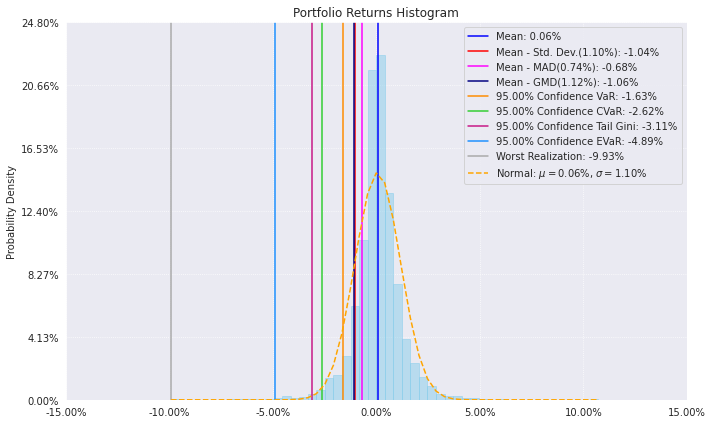

In [166]:
ax = rp.plot_hist(returns=Y,
                  w=w,
                  alpha=0.05,
                  bins=50,
                  height=6,
                  width=10,
                  ax=None)

# Walk Forward Optimization

In [161]:
pip install backtesting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 KB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173819 sha256=5067bac6a4eb6723852f587d2445e71fb7594650465b5c7009eff84737540a32
  Stored in directory: /root/.cache/pip/wheels/cd/5c/f7/aafe95c37f8b07f838fb0a8cb3177de23a38c09cbd10b447b8
Successfully built backtesting


In [164]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

import os
import pickle
from backtesting import Backtest, Strategy
from backtesting.lib import resample_apply
import matplotlib.pyplot as plt